<a href="https://colab.research.google.com/github/Ukbang/Build_with_AI_250405/blob/main/3_ReportAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install langchain langgraph langchain-google-genai langchain-core langchain-community langchain-experimental fpdf pdfplumber

In [49]:
from langchain_core.runnables import RunnableConfig
from langchain.schema import AIMessage
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from fpdf import FPDF
import random
import pdfplumber
import os
import requests
import warnings

warnings.filterwarnings("ignore")

In [50]:
google_api_key = "" # @param {"type":"string"}
tavily_api_key = "" # @param {"type":"string"}

In [51]:
os.environ["google_api_key"] = google_api_key
os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key

In [52]:
# 그래프 상태 정의

class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM response"]
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "Tool Call Result"]

In [53]:
# LLM 정의

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             temperature=0,
                             convert_system_message_to_human=True)

In [54]:
@tool
def read_pdf(file_path: str):
    """
    PDF 파일에서 텍스트를 추출하는 도구입니다.
    표 형식 또는 일반 텍스트가 포함된 PDF를 읽고 문자열로 반환합니다.

    file_path 예시: './report.pdf'
    """
    try:
        text = ""
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        return text.strip() if text.strip() else "❌ PDF에서 텍스트를 추출할 수 없습니다."
    except Exception as e:
        return f"❌ PDF 읽기 오류: {str(e)}"

In [55]:
@tool
def write_pdf(content: str, filename: str = "output.pdf", summary: bool =True):
    """
    텍스트를 PDF 파일로 저장하는 도구입니다.
    PDF형태의 문서로 만들어야할 때 이 도구를 사용하세요.
    """

    if summary:
        prompt = PromptTemplate.from_template("""
                당신은 보고서를 작성하는 어시스턴트입니다. 당신에겐 문서 모음이 제공되고 이를 잘 분석하여 보고서를 작성하여야 합니다.
                아래의 content는 문서 모음입니다. 문서의 제목, 본문을 잘 판단하고 정리하여 요약합니다.
                항상 구조화된 출력을 제공하세요.
                항상 마지막엔 인사이트도 첨부합니다.

                content : {content}
                """)

        chain = prompt | llm

        content = chain.invoke({"content":content}).content

    else:
        pass

    font_url = "https://github.com/google/fonts/raw/main/ofl/notosanskr/NotoSansKR%5Bwght%5D.ttf"
    font_path = "./fonts/NotoSansKR.ttf"

    try:
        os.mkdir("./fonts/")
        response = requests.get(font_url)
        with open(font_path, "wb") as f:
            f.write(response.content)
    except:
        pass

    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    font_path = "./fonts/NotoSansKR.ttf"  # <-- 여기에 실제 폰트 파일이 있어야 함

    try:
        pdf.add_font("NotoSans", "", font_path, uni=True)
        pdf.set_font("NotoSans", size=12)
    except:
        raise ValueError("한글 폰트를 등록할 수 없습니다.")

    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)
    pdf.output(f"./{filename}")

    return f"{filename} 저장 완료"

In [56]:
# 툴 정의
# TavilySearchResults : 웹 검색 도구
# PythonAstREPLTool : 파이썬 코드 실행 도구
# write_pdf : pdf 생성 도구
# read_pdf : pdf 읽기 도구
# file_delete : 파일 삭제 도구
# list_directory : 파일 목록 읽기 도구

tools = [TavilySearchResults(max_results=10), PythonAstREPLTool(), write_pdf, read_pdf, *FileManagementToolkit(
                                                                            selected_tools=["file_delete","list_directory"]).get_tools()]
search_tool, code_tool, write_tool, read_tool, delete_tool, listdir_tool= tools

In [57]:
# PDF 쓰기 도구 예시

write_tool.invoke({"content":"안녕하세요? \nBuild_with_AI에 오신 것을 환영합니다.", "filename":"Build_with_AI_Test.pdf", "summary":False})

'Build_with_AI_Test.pdf 저장 완료'

In [58]:
# PDF 읽기 도구 예시

print("\n\n", read_tool.invoke("Build_with_AI_Test.pdf"))



 안녕하세요?
Build_with_AI에 오신 것을 환영합니다.


In [59]:
# 파일 목록 도구 예시

print(listdir_tool.invoke(input=""))

.config
Build_with_AI_Test.pdf
.ipynb_checkpoints
fonts
sample_data


In [60]:
# 삭제 도구 예시

delete_tool.invoke("Build_with_AI_Test.pdf")

'File deleted successfully: Build_with_AI_Test.pdf.'

In [61]:
# LLM에게 도구 할당

llm_with_tools = llm.bind_tools(tools)

In [62]:
# 전체 메시지 중 마지막 메시지를 제외하고 최대 8개까지 단기 기억(history)으로 추출

def shorterm_memory(state:State):

    if len(state["messages"]) > 8:
        history = state["messages"][-8:-1]
    elif len(state["messages"]) == 1:
        history = ""
    else:
        history = state["messages"][:-1]

    return history

In [63]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [64]:
# 히스토리 기반 답변 분기를 위한 함수 설정

def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | history_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history":history,
                            "query":state["query"]})

    return result.yes_no

In [65]:
# LLM의 응답을 HistoryChecker 클래스 구조에 맞춰 파싱하도록 설정

history_checker = llm.with_structured_output(HistoryChecker)

In [66]:
# 기억 기반 답변 노드

def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.

                대화 기록 : {history}

                질문 : {query}

                """)


    chain = prompt | llm

    history = shorterm_memory(state)

    answer = chain.invoke({"history":history,
                           "query":state["query"]})

    if len(state["tool_call"]) == 0:
        return {"answer":answer.content,
                "messages":[answer],
                "tool_call":"사용된 기록 없음."}
    else:
        return {"answer":answer.content,
                "messages":[answer]}

In [67]:
# 기억 기반 답변 분기 노드

def history_node(state:State):
    if len(state["messages"]) == 1:
        return {"answer":"답변 없음",
                "tool_call":"사용된 도구 없음"}
    else:
        return state

In [68]:
# 도구 선택 노드

def select(
    state: State,
):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                이전의 대화가 다음에 어떤 도구를 사용해야하는지 힌트가 될 수 있습니다. 꼭 참조하세요.
                도구의 변화가 큰 결과를 가져올 수 있습니다.
                들어온 메시지, 정답, 이전 기록을 모두 분석하여 가장 적절한 도구를 선택하세요.

                대화 기록 : {history}

                최근 사용한 도구 : {tool_name}

                정답 : {answer}

                질문 : {query}

                """)

    chain = prompt | llm_with_tools

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                           "tool_name" : state["tool_call"],
                            "answer": state["answer"],
                            "query": state["query"]})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls

        return {"messages": result,
                "tool_call":tool_calls}
                # "tool_call":AIMessage(content=tool_calls)}
    else:
        return {"messages":AIMessage(content=f"""도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
                                        """),
                                    "tool_call":"선택된 도구 없음"}



In [69]:
# 도구 실행 노드

tool_node = ToolNode(tools)

In [70]:
class AnswerChecker(BaseModel):
    """
    정답 분류기입니다.

    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
    """


    end : Literal["end", "tool"] = Field(..., description="""You are the answer sorter.

                                                                Determine if the correct answer has solved the question.
                                                                If the question is not resolved, use the tool until it is resolved.

                                                                Return "end" if you solved the question, or "tool" if you didn't.""")

In [71]:
# LLM의 응답을 AnswerChecker 클래스 구조에 맞춰 파싱하도록 설정

answer_checker = llm.with_structured_output(AnswerChecker)

In [72]:
# 답변 확인 노드

def response(state:State):

    return {"answer":state["messages"][-1]}

In [73]:
# 답변 완성 판단 분기 함수

def answer_check(state:State):

    prompt = PromptTemplate.from_template("""
    당신은 정답 분류기 어시스턴트입니다.

    정답이 질문을 해결하였는지 여부를 판단합니다.
    질문을 해결하지 못했다면 도구를 이용합니다.

    질문을 해결하였다면 "end", 아니라면 "tool"을 반환합니다.

    기존 History도 참고하여 답변하세요.

    History : {history}

    정답 : {answer}

    질문 : {query}
    """)

    chain = prompt | answer_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                            "answer": state["answer"],
                            "query": state["query"]})

    return result.end

In [74]:
# 그래프 정의

graph_builder = StateGraph(State)

In [75]:
# 노드 및 엣지 정의

graph_builder.add_node("history_node", history_node)
graph_builder.add_node("memory_chat", memory_chat)
graph_builder.add_node("select", select)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                            history_check,
                            {"yes":"memory_chat",
                             "no":"select"})
graph_builder.add_edge("select", "tools")
graph_builder.add_edge("tools", "response")
graph_builder.add_edge("memory_chat", "response")
graph_builder.add_conditional_edges("response",
                                    answer_check,
                                    {"end":END,
                                    "tool":"select"});

In [76]:
# 메모리 설정 및 그래프 컴파일

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

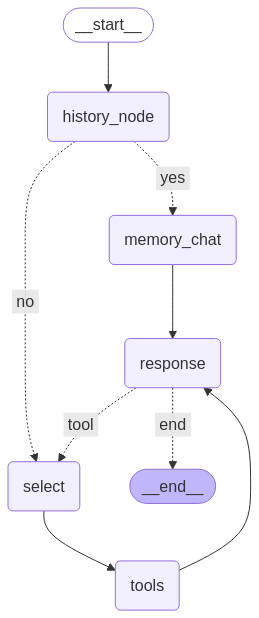

In [77]:
# 그래프 시각화
# 가끔 "ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)"라는 에러가 발생
# 시간 초과로 그래프 생성에 실패했다는 메시지일뿐 기능과는 관계없으니 진행해도 괜찮습니다.

graph

In [78]:
# config 재생성 노드, config의 재사용은 고려되지 않음. 재사용한다면 변수에 할당하여 사용할 것

def reset_config(limit=20):

    thread_id=random.randint(1,999999)

    config = RunnableConfig(recursion_limit=limit, configurable={"thread_id": thread_id})

    return config

In [79]:
# 출력 함수 정의
# mode = "values" : 상태의 키, 값의 형태로 반환
# mode = "updates" : 업데이트되는 값만 반환

def streaming(query, config, mode="values"):

    result = graph.stream({"messages":("user", query),
                         "query":query}, config=config, stream_mode=mode)

    if mode == "values":
        for step in result:
            for k, v in step.items():
                if k == "messages":
                    v[-1].pretty_print()
    elif mode == "updates":
        for step in result:
            for k,v in step.items():
                print(f"\n\n=== {k} ===\n\n")
                print(v)

    return

In [80]:
config = reset_config()

query = "1+1은 뭔가요?"

streaming(query, config)

================================ Human Message =================================

1+1은 뭔가요?
================================ Human Message =================================

1+1은 뭔가요?
================================== Ai Message ==================================

2
================================== Ai Message ==================================

2


In [81]:
config = reset_config()

query = "피엔티라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf파일로 받기를 희망합니다."

streaming(query, config)

================================ Human Message =================================

피엔티라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf파일로 받기를 희망합니다.
================================ Human Message =================================

피엔티라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf파일로 받기를 희망합니다.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5bcf3570-2360-4e31-8266-cd7841e9f808)
 Call ID: 5bcf3570-2360-4e31-8266-cd7841e9f808
  Args:
    query: 피엔티 회사
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "피엔티 - 위키백과, 우리 모두의 백과사전", "url": "https://ko.wikipedia.org/wiki/%ED%94%BC%EC%97%94%ED%8B%B0", "content": "피엔티 주식회사(PNT Co. Ltd.)는 Roll to Roll 기술을 바탕으로 각종 디스플레이 소재용 필름, 2차 전지의 음극 및 분리막 소재, Copper 등의 코팅 및 슬리터 장비를 제작하는 코스닥 상장 기업이다. 매출구성은 소재 81%, 2차전지 18%, 반도체 1% 가량으로 이루어진다. [...] 형태 | 주식회사\n창립 | 2003/12/30 (상장일: 2012/07/06)\n시장 정보 | 한국:137400\n산업 분야 | 디스플레이

In [82]:
config = reset_config()

query = "피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요."

streaming(query, config)

================================ Human Message =================================

피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요.
================================ Human Message =================================

피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5290e6f1-6fb4-4bd2-ac73-99a540819b4c)
 Call ID: 5290e6f1-6fb4-4bd2-ac73-99a540819b4c
  Args:
    query: 피엔티 경쟁사
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "피엔티의 사업분석 및 고객사에 대하여 : 네이버 블로그", "url": "https://blog.naver.com/humanindicator/222353810766", "content": "피엔티의 경쟁사는 롤투롤 장비회사의 양대 산맥인 '씨아이에스'다. 주 거래처는 LG이며 최근 노스볼트의 전극공정까지 수주를 따낸 핫한 기업이다. 둘다", "score": 0.8846886}, {"title": "피엔티 - 오렌지보드", "url": "https://orangeboard.co.kr/@New_Jusiks/%ED%94%BC%EC%97%94%ED%8B%B0-%EB%8F%85%EB%B3%B4%EC%A0%81-1%EC%9C%84-%EA%B7%B8-%EB%84%88%EB%A8%B8%EB%A5%BC-%EB%B0%94%EB%9D%B

In [85]:
config = reset_config()

query = "현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘"

streaming(query, config)

================================ Human Message =================================

현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘
================================ Human Message =================================

현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘
================================== Ai Message ==================================
Tool Calls:
  list_directory (2d26024e-6c9a-44a5-9859-c28f6b43b9bb)
 Call ID: 2d26024e-6c9a-44a5-9859-c28f6b43b9bb
  Args:
================================= Tool Message =================================
Name: list_directory

.config
피엔티 경쟁사 보고서
.ipynb_checkpoints
피엔티 보고서
fonts
sample_data
================================= Tool Message =================================
Name: list_directory

.config
피엔티 경쟁사 보고서
.ipynb_checkpoints
피엔티 보고서
fonts
sample_data
================================== Ai Message ==================================

현재 폴더에 있는 PDF 파일들을 삭제하기 위해 먼저 파일 목록을 확인하고, 그 다음 PDF 파일들을 삭제해야 합니다. 이전 단계에서 `list_directory` 도구를 사용하여 파일 목록을 확인했으므로, 이제 `file_delete` 도구를 사용하여 PDF 파일들을 삭제해야 합니

In [86]:
config = reset_config()

code = """
아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)

```
"""

streaming(code, config)

================================ Human Message =================================


아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)

```

================================ Human Message =================================


아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)

```

================================== Ai Message ==================================
Tool Calls:
  python_repl_ast (41596b9b-73d1-417b-af46-b1c4e49dabb0)
 Call ID: 41596b9b-73d1-417b-af46-b1c4e49dabb0
  Args:
    query: 
result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)
1번째 출력:  1
2번째 출력:  2
3번째 출력:  3
4번째 출력:  4
5번째 출력:  5
6번째 출력:  6
7번째 출력:  7
8번째 출력:  8
9번째 출력:  9
10번째 출력:  10
11번째 출력:  11
12번째 출력:  12
13번째 출력:  13
14번째 출력:  14
15번째 출력:  15
16번째 출력:  16
17번째 출력:  17
18번째 출력:  18
19번째 출력:  19
20번째

In [87]:
config = reset_config()

streaming("""
          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.""", config)

================================ Human Message =================================


          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
================================ Human Message =================================


          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5ca8e86d-2c60-40b1-a00e-89e6eb616ba4)
 Call ID: 5ca8e86d-2c60-40b1-a00e-89e6eb616ba4
  Args:
    query: 모두의연구소
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "모두의연구소 2025년 기업정보 - 직원수, 근무환경, 복리후생 등", "url": "https://www.jobkorea.co.kr/recruit/co_read/c/modulabs", "content": "기업소개. 모두의연구소는 AI 교육인 아이펠과 작년에 새롭게 런칭된 SW 교육, 그리고 다양한 주제가 있는 커뮤니티를 기반으로 교육 및 연구 서비스를 제공하고 있어요. '", "score"

}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 4
}
].


================================= Tool Message =================================
Name: write_pdf

모두의연구소_레포트.pdf 저장 완료


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 2
}
]

In [89]:
config = reset_config()

query = "'모두의연구소_레포트.pdf'라는 파일 삭제해줘"

streaming(query, config)

================================ Human Message =================================

'모두의연구소_레포트.pdf'라는 파일 삭제해줘
================================ Human Message =================================

'모두의연구소_레포트.pdf'라는 파일 삭제해줘
================================== Ai Message ==================================

죄송합니다. 파일 삭제 권한이 없습니다. 제가 직접 파일을 삭제해 드릴 수는 없습니다.
================================== Ai Message ==================================

죄송합니다. 파일 삭제 권한이 없습니다. 제가 직접 파일을 삭제해 드릴 수는 없습니다.
================================== Ai Message ==================================

도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
================================== Ai Message ==================================

도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
================================== Ai Message ==================================

도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
================================== Ai Message ==================================
Tool Calls:
  file_delete (b9da83e1-c139-409e-80c1-e3f18fd5b5e2)
 Call ID: b9da83e1-c139-409e-80c